# Base Visualization 

## 0. Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import torch

import re

import warnings
warnings.filterwarnings(action='ignore')

def set_seed(seed: int) -> None:
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

seed = 1234
set_seed(seed)

In [2]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# 나눔 폰트 경로를 직접 설정 
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = fontprop.get_name()

In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# Hugging Face의 병렬 처리가 비활성화
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [5]:
# max_len 도출
from typing import List

def calculate_optimal_max_len(lengths: List[int], thresholds=[128, 256, 512], percentile=90) -> int:
    """
    Calculates the optimal max_len based on the specified percentile of the lengths.
    
    Args:
        lengths (List[int]): List of lengths of each text sample.
        thresholds (List[int]): Possible threshold values to choose from.
        percentile (int): The percentile to use as the cutoff for length.

    Returns:
        int: The optimal max_len based on the given percentile.
    """
    # Calculate the length at the specified percentile
    max_len_suggestion = np.percentile(lengths, percentile)
    
    # Find the closest threshold
    optimal_max_len = min(thresholds, key=lambda x: abs(x - max_len_suggestion))
    
    # Plot length distribution and percentile line
    plt.hist(lengths, bins=30, alpha=0.6, color='b', edgecolor='black')
    plt.axvline(max_len_suggestion, color='red', linestyle='--', label=f'{percentile}th percentile = {int(max_len_suggestion)}')
    plt.axvline(optimal_max_len, color='green', linestyle='-', label=f'Chosen max_len = {optimal_max_len}')
    plt.xlabel('Text Length')
    plt.ylabel('Frequency')
    plt.title('Text Length Distribution with Optimal max_len')
    plt.legend()
    plt.show()
    
    return optimal_max_len

In [6]:
# 코사인 유사도 및 유클리디안 거리 시각화 함수
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity

def visualize_similarity_distance(vector1, vector2):
    # 코사인 유사도 및 유클리디안 거리 계산
    similarity_block = cosine_similarity(vector1, vector2)
    euc_distances = euclidean_distances(vector1, vector2)
    
    # 시각화
    plt.figure(figsize=(12, 5))
    
    # 코사인 유사도 히트맵
    plt.subplot(1, 2, 1)
    sns.heatmap(similarity_block, cmap="YlGnBu", xticklabels=False, yticklabels=False)
    plt.title("Cosine Similarity")
    plt.xlabel("train")
    plt.ylabel("test")
    
    # 유클리디안 거리 히트맵
    plt.subplot(1, 2, 2)
    sns.heatmap(euc_distances, cmap="YlGnBu", xticklabels=False, yticklabels=False)
    plt.title("Euclidean Distance")
    plt.xlabel("train")
    plt.ylabel("test")
    
    plt.show()

## 1. Load Data

In [7]:
from datasets import load_dataset
data_cn = load_dataset("lbox/lbox_open", "casename_classification", download_mode="force_redownload")
data_cn

Dataset lbox_open downloaded and prepared to /home/keti/.cache/huggingface/datasets/lbox___lbox_open/casename_classification/0.2.0/3d5761e2d9292b674a2adabbe7f4bc200d1985908e6f657e7953c9bf247da7ae. Subsequent calls will reuse this data.


100%|██████████| 4/4 [00:00<00:00, 2106.63it/s]


DatasetDict({
    train: Dataset({
        features: ['id', 'casetype', 'casename', 'facts'],
        num_rows: 8000
    })
    validation: Dataset({
        features: ['id', 'casetype', 'casename', 'facts'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['id', 'casetype', 'casename', 'facts'],
        num_rows: 1000
    })
    test2: Dataset({
        features: ['id', 'casetype', 'casename', 'facts'],
        num_rows: 1294
    })
})

In [8]:
# train + test 추출
train_data = data_cn['train']
test_data = data_cn['test']

train = pd.DataFrame(train_data)
test = pd.DataFrame(test_data)

train = train[['casetype', 'casename', 'facts']]
test = test[['casetype', 'casename', 'facts']]

In [9]:
train

,casetype,casename,facts
0,criminal,감염병의예방및관리에관한법률위반,피고인은 고양시 일산서구 B건물 C동에서 ‘D'을 실질적으로 운영하는 자이다.\n보...
1,criminal,감염병의예방및관리에관한법률위반,피고인은 성남시 중원구 B에서 ‘C'이라는 상호의 당구장을 운영하는 사람이다.\n중...
2,criminal,감염병의예방및관리에관한법률위반,"질병관리청장, 시·도지사 또는 시장·군수·구청장은 감염병을 예방하기 위하여나 감염병..."
3,criminal,감염병의예방및관리에관한법률위반,"질병관리청장, 시ㆍ도지사 또는 시장ㆍ군수ㆍ구청장은 감염병이 유행하면 감염병의 전파를..."
4,criminal,감염병의예방및관리에관한법률위반,"보건복지부장관, 시·도지사 또는 시장·군수·구청장은 감염병의 전파 방지 및 예방을 ..."
...,...,...,...
7995,criminal,횡령,범죄전력\n피고인은 2019. 12. 19. 서울중앙지방법원에서 도로교통법위반(음주...
7996,criminal,횡령,"기초사실\n피고인 B은 2018. 7.경 피고인 A에게 ‘신용도 문제가 있으니, 외..."
7997,criminal,횡령,범죄전력\n피고인 A은 2018. 4. 20. 대구지방법원 안동지원에서 사기죄 등으...
7998,criminal,횡령,피고인은 건설현장에서 목수로 일하는 사람으로 2012.경 지인의 소개로 피해자 B을...


In [10]:
test

,casetype,casename,facts
0,criminal,감염병의예방및관리에관한법률위반,"질병관리청장, 시·도지사 또는 시장·군수·구청장은 감염병이 유행하면 감염병의 전파를..."
1,criminal,감염병의예방및관리에관한법률위반,"질병관리청장, 시․도지사 또는 시장․군수․구청장은 감염병을 예방하기 위하여 감염병의..."
2,criminal,감염병의예방및관리에관한법률위반,보건복지부장관은 2020. 1. 8.경 코로나바이러스감염증-19(이하 ‘코로나-19...
3,criminal,감염병의예방및관리에관한법률위반,"질병관리청장, 시·도지사 또는 시장·군수·구청장은 감염병을 예방하기 위하여 흥행, ..."
4,criminal,감염병의예방및관리에관한법률위반,"피고인들은 수원시 영통구 C, D호에서 E 유흥주점을 공동으로 운영하는 사람들이다...."
...,...,...,...
995,criminal,횡령,피고인은 2019. 5.경 청주시 흥덕구 B에 있는 피해자 C이 운영하는 'D' 주...
996,criminal,횡령,"피고인은 2019. 1. 12.경 전남 목포시 B, 2층 C직업소개소에서 2019...."
997,criminal,횡령,피고인은 2018. 4. 24.경부터 2018. 7. 9.까지 당진시 B에 있는 C...
998,criminal,횡령,범죄전력\n피고인은 2019. 9. 6. 수원지방법원 평택지원에서 횡령죄로 징역 8...


In [29]:
train.describe()

,casetype,casename,facts
count,8000,8000,8000
unique,2,100,7997
top,criminal,감염병의예방및관리에관한법률위반,범죄전력\n피고인은 2018. 8. 10. 창원지방법원에서 도로교통법위반(음주운전)...
freq,5440,80,2


In [30]:
test.describe()

,casetype,casename,facts
count,1000,1000,1000
unique,2,100,1000
top,criminal,감염병의예방및관리에관한법률위반,"질병관리청장, 시·도지사 또는 시장·군수·구청장은 감염병이 유행하면 감염병의 전파를..."
freq,680,10,1


## 2. Embedding
Load Model 

In [11]:
# KLUE RoBERTa 모델과 토크나이저 설정
from transformers import AutoModel, AutoTokenizer

model_name = "klue/roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
model = AutoModel.from_pretrained(model_name).to(device)

2024-11-18 10:29:44.086409: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-18 10:29:44.087509: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-18 10:29:44.108153: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-18 10:29:44.448882: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.

In [ ]:
from collections import Counter
# 토큰화
tokens = [token for sentence in train["facts"] for token in tokenizer.tokenize(sentence)]

# 토큰 빈도 계산
token_counts = Counter(tokens)

# 빈도가 높은 상위 30개 서브워드 출력
print(token_counts.most_common(30))

[('.', 178908), (',', 90117), ('##을', 72006), ('##에', 69028), ('##의', 55973), ('##는', 51218), ('##하', 47542), ('##은', 46418), ('##를', 44066), ('##다', 38694), ('##로', 36147), ('##였', 29626), ('피고인', 29359), (')', 28609), ('이', 25963), ('(', 24640), ('##으로', 24391), ('##이', 24229), ('##고', 24085), ('피해자', 23743), ("'", 22153), ('##게', 21663), ('위', 20214), ('##하여', 20118), ('##에서', 19976), ('1', 19616), ('‘', 19066), ('##한', 18455), ('사건', 17541), ('##가', 17428)]


Token indices sequence length is longer than the specified maximum sequence length for this model (1147 > 512). Running this sequence through the model will result in indexing errors


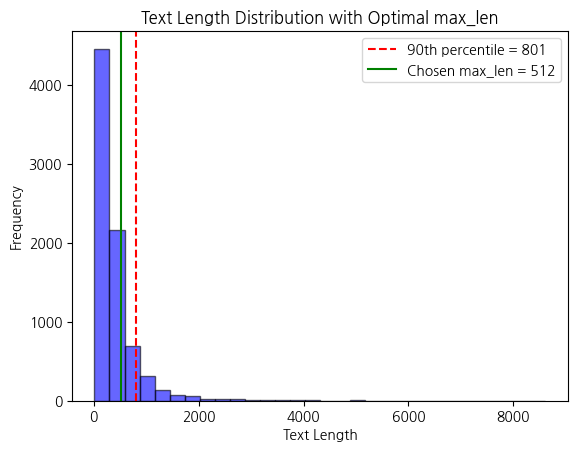

In [ ]:
# max_len 길이 구하기
token_lengths = [len(tokenizer.encode(text)) for text in train["facts"]]

# 최적의 max_len 계산
max_len = calculate_optimal_max_len(token_lengths)

In [14]:
from torch.utils.data import DataLoader, Dataset

# 1. 커스텀 데이터셋 정의
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        self.texts = self.data.apply(lambda row: f"{row['casetype']} {row['casename']} {row['facts']}", axis=1)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts.iloc[idx]
    
# 2. 데이터셋 준비
train_dataset = CustomDataset(train)
test_dataset = CustomDataset(test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [15]:
# 3. 임베딩 생성 함수
def generate_embeddings(data_loader):
    embeddings = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            inputs = tokenizer(list(batch), return_tensors="pt", padding=True, truncation=True, max_length=512).to("cuda")
            outputs = model(**inputs)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]  # [CLS] 토큰의 임베딩 사용
            embeddings.append(cls_embeddings.cpu())
    return torch.cat(embeddings).numpy()

# Train과 Test 데이터 임베딩 생성
train_embeddings = generate_embeddings(train_loader)
test_embeddings = generate_embeddings(test_loader)

In [40]:
train_embeddings[:,]

array([[ 0.06429604, -0.61878175, -0.18445766, ..., -0.12379471,
        -0.16051672,  0.17163177],
       [ 0.06691053, -0.60823566, -0.23118639, ..., -0.04772638,
        -0.14795355,  0.163045  ],
       [ 0.10525767, -0.6243947 , -0.18677904, ..., -0.0934683 ,
        -0.20714073,  0.19851878],
       ...,
       [ 0.09895771, -0.5934314 , -0.11441792, ..., -0.11415292,
        -0.20126796,  0.14857946],
       [ 0.06754216, -0.64917374, -0.23283386, ..., -0.06796113,
        -0.15088974,  0.1390612 ],
       [ 0.14489946, -0.57854337, -0.07915353, ..., -0.09883964,
        -0.10279753,  0.1551393 ]], dtype=float32)

In [41]:
test_embeddings[:,]

array([[ 0.08438456, -0.58511615, -0.1287583 , ..., -0.09243606,
        -0.22435664,  0.2083018 ],
       [ 0.0569452 , -0.655355  , -0.24090505, ..., -0.08533194,
        -0.21866977,  0.16766584],
       [ 0.08832715, -0.6206383 , -0.17074154, ..., -0.10208819,
        -0.21520853,  0.17865412],
       ...,
       [ 0.14552948, -0.6181526 , -0.19782981, ..., -0.02116453,
        -0.09598609,  0.15391146],
       [ 0.08314348, -0.603458  , -0.13105883, ..., -0.08914552,
        -0.178756  ,  0.14624806],
       [ 0.13101329, -0.65362114, -0.2118631 , ..., -0.03764229,
        -0.12108591,  0.16324058]], dtype=float32)

## 3. visualization

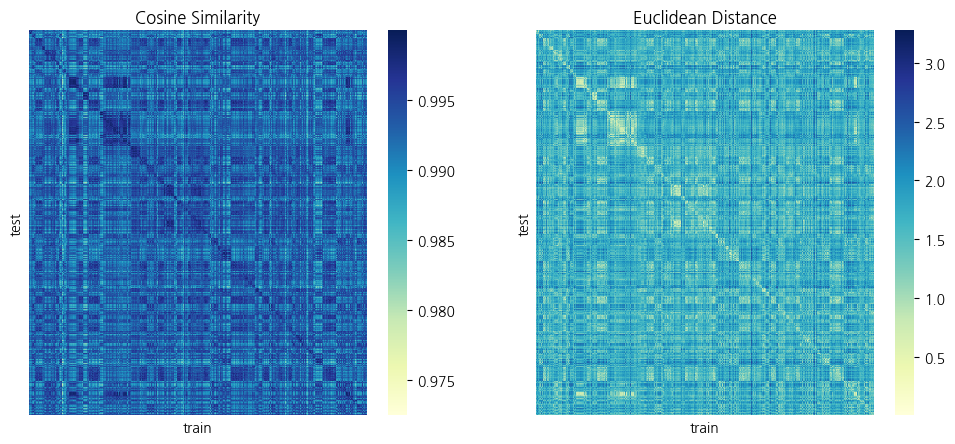

In [46]:
visualize_similarity_distance(train_embeddings, test_embeddings)

방향적으로 유사한 형태임을 알 수 있음

### 3.1 T-SNE
- 데이터 간의 세부적인 군집

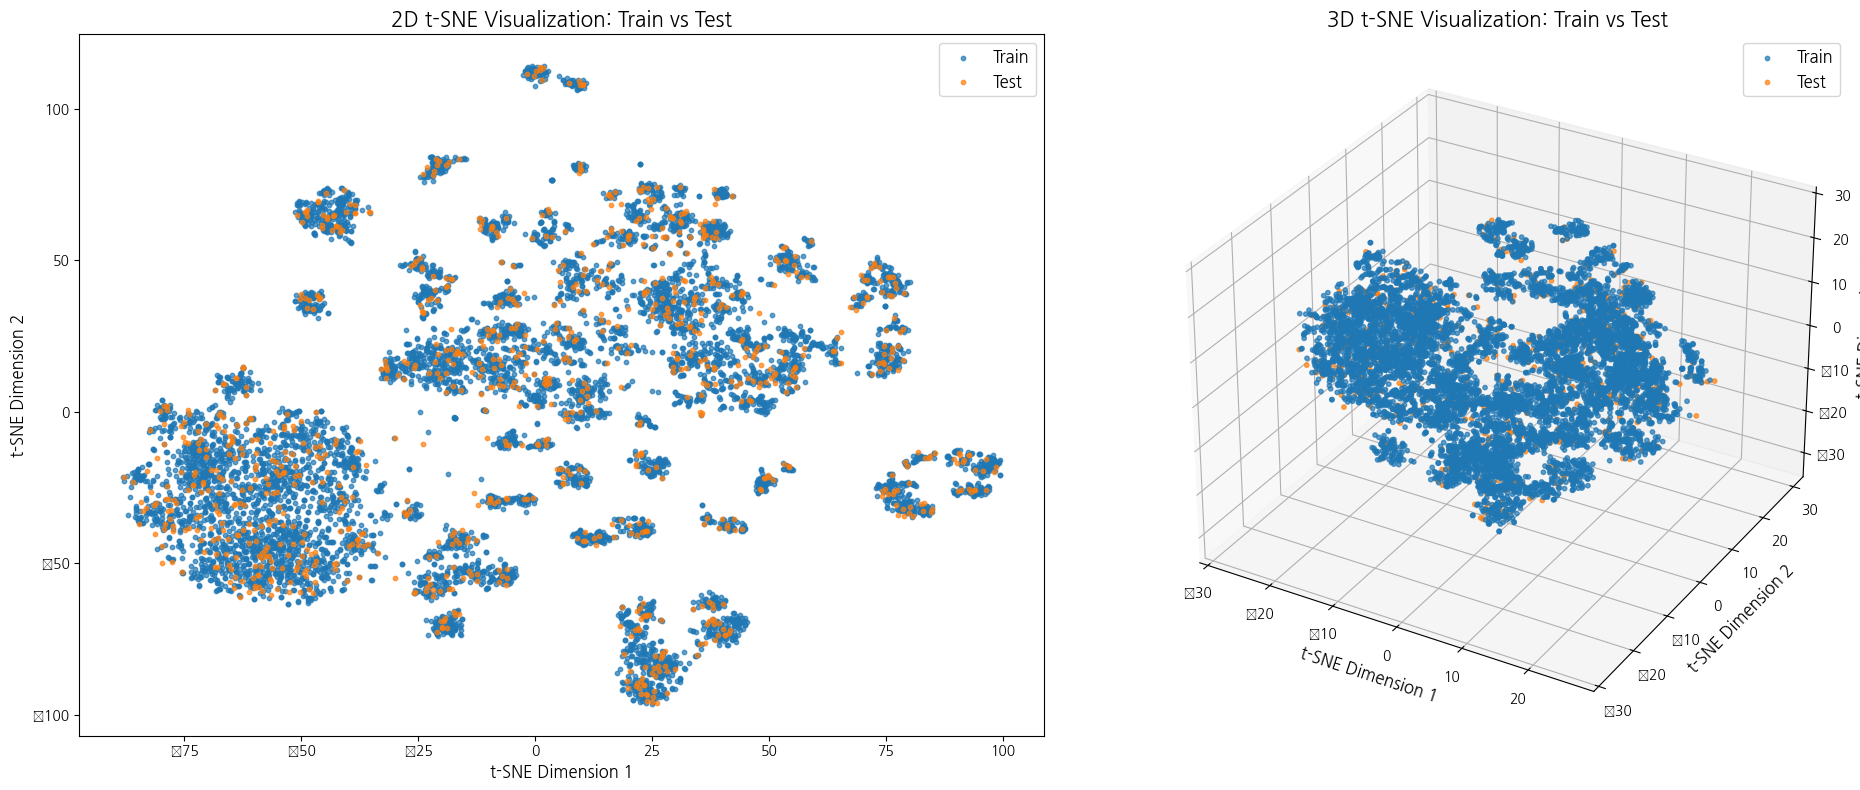

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 3D 시각화를 위한 모듈
import numpy as np

def tsne_plot_2d_3d(train_embeddings, test_embeddings, train_label="Train", test_label="Test"):
    """
    Train과 Test 임베딩을 비교 시각화하는 함수 (2D와 3D t-SNE)
    Args:
        train_embeddings (numpy.ndarray): Train 데이터의 RoBERTa 임베딩
        test_embeddings (numpy.ndarray): Test 데이터의 RoBERTa 임베딩
        train_label (str): Train 데이터 레이블
        test_label (str): Test 데이터 레이블
    """
    # t-SNE 모델 초기화 및 학습 (2D와 3D 결과를 각각 생성)
    embeddings = np.vstack([train_embeddings, test_embeddings])  # 두 데이터를 하나로 결합
    tsne_model_2d = TSNE(
        perplexity=40,
        n_components=2,
        init="pca",
        n_iter=2500,
        random_state=23
    )
    tsne_model_3d = TSNE(
        perplexity=40,
        n_components=3,
        init="pca",
        n_iter=2500,
        random_state=23
    )

    tsne_values_2d = tsne_model_2d.fit_transform(embeddings)
    tsne_values_3d = tsne_model_3d.fit_transform(embeddings)

    # Train/Test 데이터의 분리된 레이블 생성
    labels = [train_label] * len(train_embeddings) + [test_label] * len(test_embeddings)

    # t-SNE 결과 분리
    x_2d, y_2d = tsne_values_2d[:, 0], tsne_values_2d[:, 1]
    x_3d, y_3d, z_3d = tsne_values_3d[:, 0], tsne_values_3d[:, 1], tsne_values_3d[:, 2]

    # 시각화 (1x2 서브플롯 생성)
    fig = plt.figure(figsize=(20, 8))

    # 2D 시각화
    ax1 = fig.add_subplot(1, 2, 1)
    for label in set(labels):
        idx = [i for i, lbl in enumerate(labels) if lbl == label]
        ax1.scatter(
            [x_2d[i] for i in idx],
            [y_2d[i] for i in idx],
            label=label,
            s=10, alpha=0.7
        )
    ax1.set_title("2D t-SNE Visualization: Train vs Test", fontsize=15)
    ax1.set_xlabel("t-SNE Dimension 1", fontsize=12)
    ax1.set_ylabel("t-SNE Dimension 2", fontsize=12)
    ax1.legend(loc="best", fontsize=12)

    # 3D 시각화
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    for label in set(labels):
        idx = [i for i, lbl in enumerate(labels) if lbl == label]
        ax2.scatter(
            [x_3d[i] for i in idx],
            [y_3d[i] for i in idx],
            [z_3d[i] for i in idx],
            label=label,
            s=10, alpha=0.7
        )
    ax2.set_title("3D t-SNE Visualization: Train vs Test", fontsize=15)
    ax2.set_xlabel("t-SNE Dimension 1", fontsize=12)
    ax2.set_ylabel("t-SNE Dimension 2", fontsize=12)
    ax2.set_zlabel("t-SNE Dimension 3", fontsize=12)
    ax2.legend(loc="best", fontsize=12)

    # 전체 플롯 표시
    plt.tight_layout()
    plt.show()

tsne_plot_2d_3d(train_embeddings, test_embeddings)

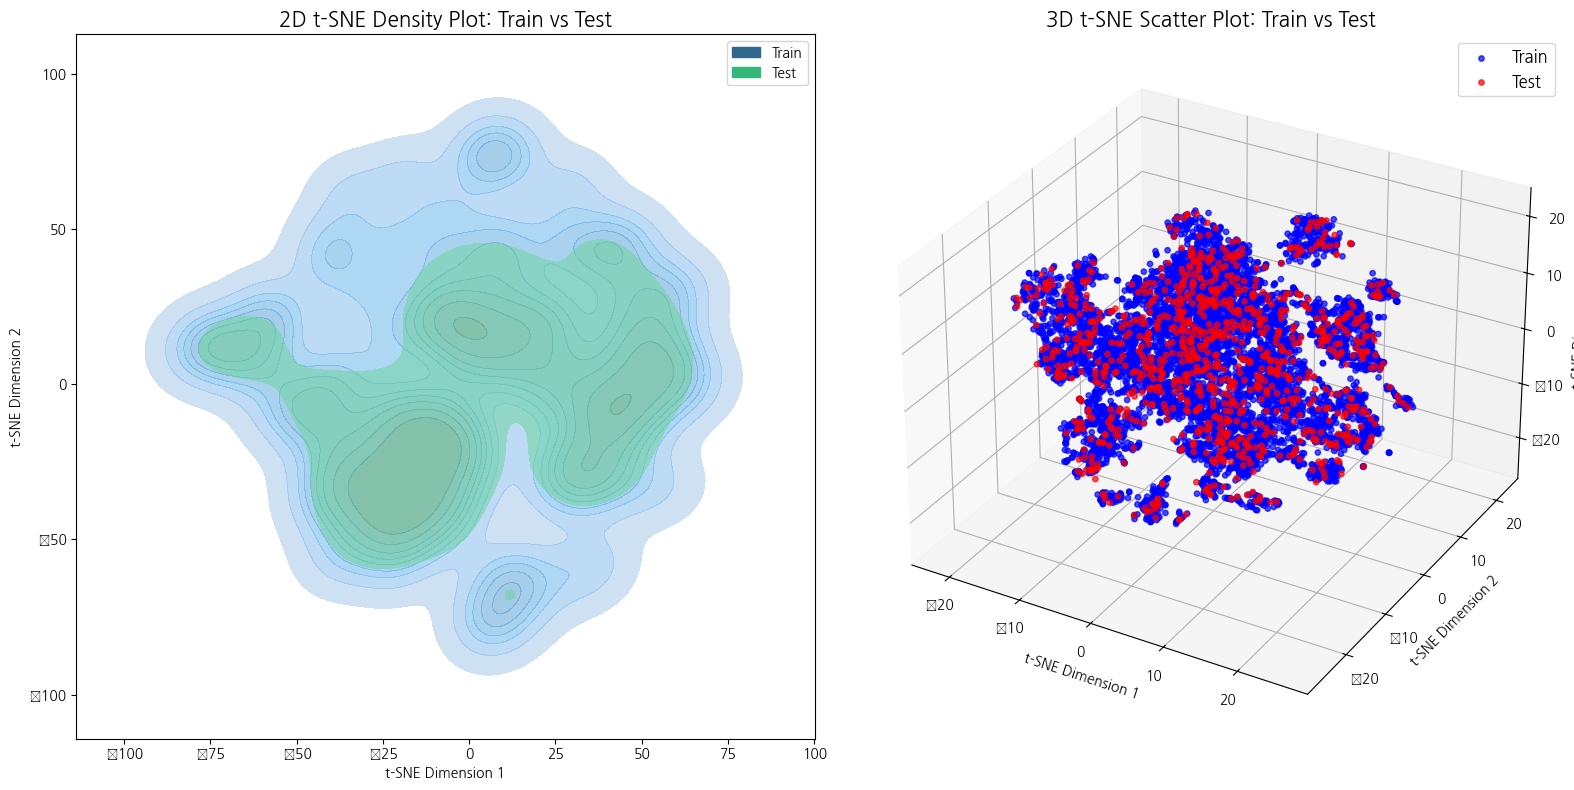

In [60]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np

def tsne_density_plot_2d_3d_fixed(train_embeddings, test_embeddings):
    """
    2D 및 3D t-SNE 밀도 플롯: Train vs Test (Train/Test 색상 명확히 구분)
    """
    # t-SNE 모델 학습
    embeddings = np.vstack([train_embeddings, test_embeddings])
    
    # 2D t-SNE
    tsne_2d_model = TSNE(n_components=2, perplexity=40, random_state=42)
    new_values_2d = tsne_2d_model.fit_transform(embeddings)
    
    # 3D t-SNE
    tsne_3d_model = TSNE(n_components=3, perplexity=40, random_state=42)
    new_values_3d = tsne_3d_model.fit_transform(embeddings)

    # 데이터 분리
    labels = ['Train'] * len(train_embeddings) + ['Test'] * len(test_embeddings)
    x_2d, y_2d = new_values_2d[:, 0], new_values_2d[:, 1]
    x_3d, y_3d, z_3d = new_values_3d[:, 0], new_values_3d[:, 1], new_values_3d[:, 2]

    # 1x2 크기의 그래프 생성
    fig = plt.figure(figsize=(16, 8))

    # 2D Density Plot
    ax1 = fig.add_subplot(121)
    sns.kdeplot(x=x_2d, y=y_2d, hue=labels, fill=True, palette="viridis", alpha=0.5, ax=ax1)
    ax1.set_title("2D t-SNE Density Plot: Train vs Test", fontsize=15)
    ax1.set_xlabel("t-SNE Dimension 1")
    ax1.set_ylabel("t-SNE Dimension 2")

    # 3D Plot with Train/Test distinction
    ax2 = fig.add_subplot(122, projection='3d')
    colors = {'Train': 'blue', 'Test': 'red'}
    for label in set(labels):
        idx = [i for i, lbl in enumerate(labels) if lbl == label]
        ax2.scatter(
            [x_3d[i] for i in idx],
            [y_3d[i] for i in idx],
            [z_3d[i] for i in idx],
            c=colors[label],
            label=label,
            alpha=0.7,
            s=15
        )

    ax2.set_title("3D t-SNE Scatter Plot: Train vs Test", fontsize=15)
    ax2.set_xlabel("t-SNE Dimension 1")
    ax2.set_ylabel("t-SNE Dimension 2")
    ax2.set_zlabel("t-SNE Dimension 3")
    ax2.legend(loc="best", fontsize=12)

    plt.tight_layout()
    plt.show()

# Example Call
tsne_density_plot_2d_3d_fixed(train_embeddings, test_embeddings)

### 3.2 UMAP

- data 간의 전반적인 군집

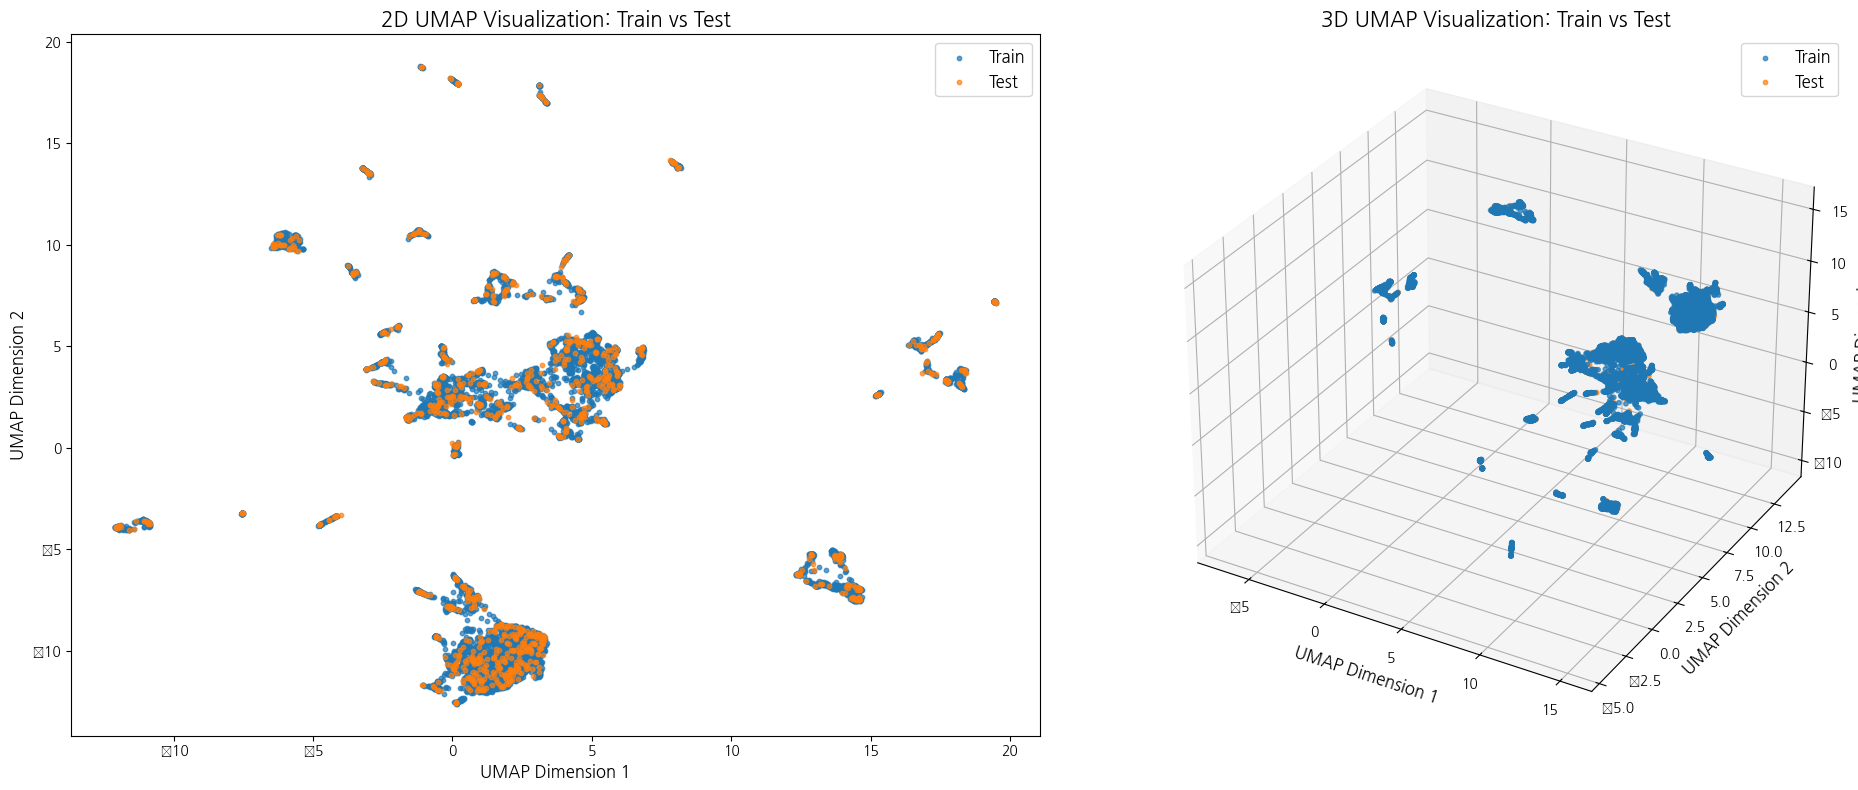

In [61]:
import umap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 3D 시각화를 위한 모듈
import numpy as np

def umap_plot_2d_3d(train_embeddings, test_embeddings, train_label="Train", test_label="Test"):
    """
    Train과 Test 임베딩을 비교 시각화하는 함수 (2D와 3D UMAP)
    Args:
        train_embeddings (numpy.ndarray): Train 데이터의 RoBERTa 임베딩
        test_embeddings (numpy.ndarray): Test 데이터의 RoBERTa 임베딩
        train_label (str): Train 데이터 레이블
        test_label (str): Test 데이터 레이블
    """
    # UMAP 모델 초기화 및 학습 (2D와 3D 결과를 각각 생성)
    embeddings = np.vstack([train_embeddings, test_embeddings])  # 두 데이터를 하나로 결합
    umap_model_2d = umap.UMAP(n_components=2, random_state=42)
    umap_model_3d = umap.UMAP(n_components=3, random_state=42)

    umap_values_2d = umap_model_2d.fit_transform(embeddings)
    umap_values_3d = umap_model_3d.fit_transform(embeddings)

    # Train/Test 데이터의 분리된 레이블 생성
    labels = [train_label] * len(train_embeddings) + [test_label] * len(test_embeddings)

    # UMAP 결과 분리
    x_2d, y_2d = umap_values_2d[:, 0], umap_values_2d[:, 1]
    x_3d, y_3d, z_3d = umap_values_3d[:, 0], umap_values_3d[:, 1], umap_values_3d[:, 2]

    # 시각화 (1x2 서브플롯 생성)
    fig = plt.figure(figsize=(20, 8))

    # 2D 시각화
    ax1 = fig.add_subplot(1, 2, 1)
    for label in set(labels):
        idx = [i for i, lbl in enumerate(labels) if lbl == label]
        ax1.scatter(
            [x_2d[i] for i in idx],
            [y_2d[i] for i in idx],
            label=label,
            s=10, alpha=0.7
        )
    ax1.set_title("2D UMAP Visualization: Train vs Test", fontsize=15)
    ax1.set_xlabel("UMAP Dimension 1", fontsize=12)
    ax1.set_ylabel("UMAP Dimension 2", fontsize=12)
    ax1.legend(loc="best", fontsize=12)

    # 3D 시각화
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    for label in set(labels):
        idx = [i for i, lbl in enumerate(labels) if lbl == label]
        ax2.scatter(
            [x_3d[i] for i in idx],
            [y_3d[i] for i in idx],
            [z_3d[i] for i in idx],
            label=label,
            s=10, alpha=0.7
        )
    ax2.set_title("3D UMAP Visualization: Train vs Test", fontsize=15)
    ax2.set_xlabel("UMAP Dimension 1", fontsize=12)
    ax2.set_ylabel("UMAP Dimension 2", fontsize=12)
    ax2.set_zlabel("UMAP Dimension 3", fontsize=12)
    ax2.legend(loc="best", fontsize=12)

    # 전체 플롯 표시
    plt.tight_layout()
    plt.show()

# Example Call
umap_plot_2d_3d(train_embeddings, test_embeddings)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


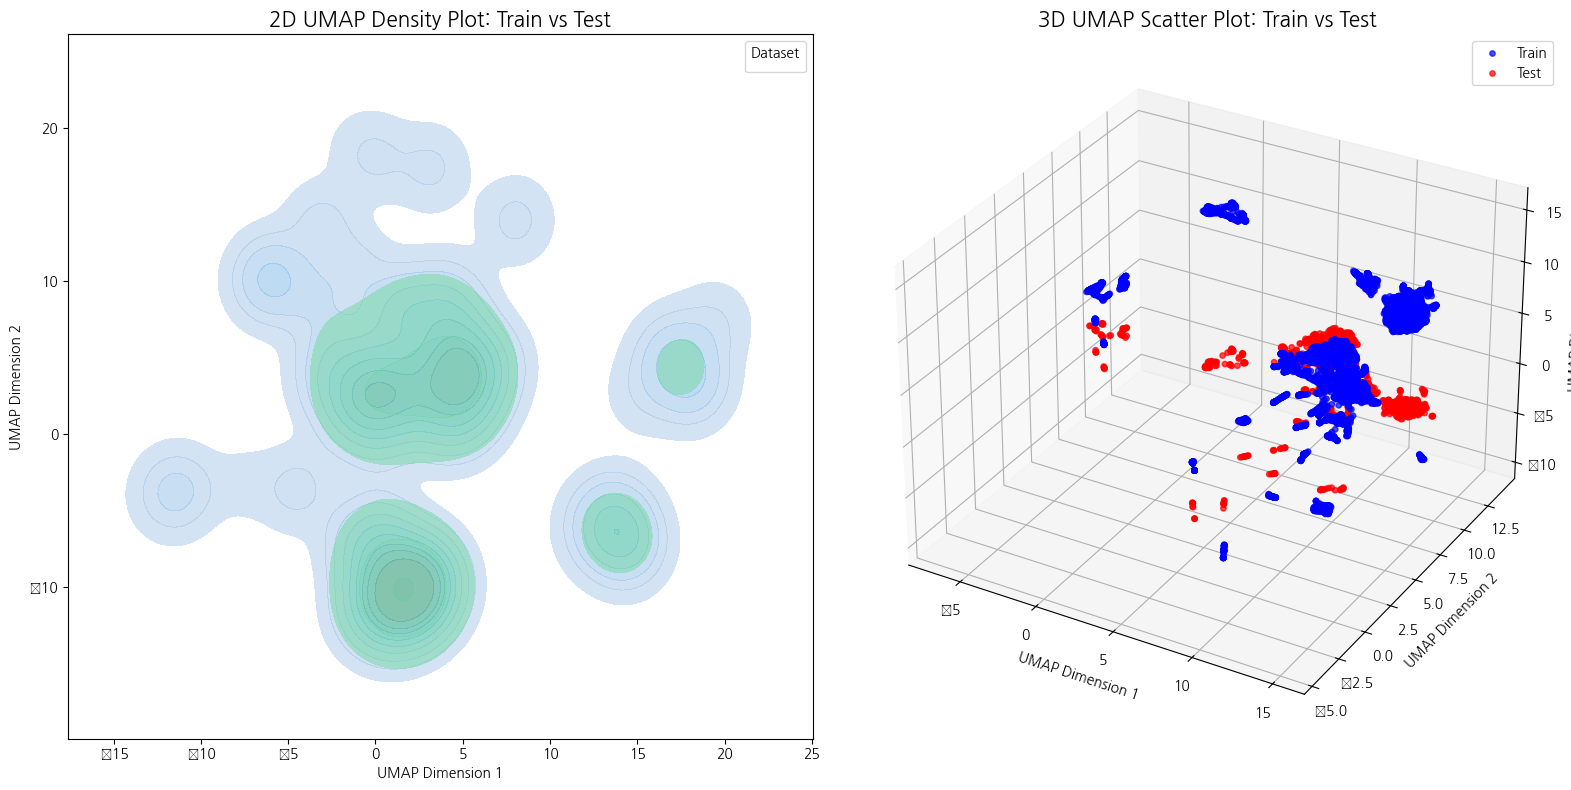

In [64]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from umap import UMAP
import numpy as np

def umap_density_plot(train_embeddings, test_embeddings):
    """
    Train과 Test 데이터를 비교하며 UMAP Density Plot을 1x2 서브플롯으로 진행하는 함수.
    - 2D Density Plot
    - 3D Density Plot (Train/Test 구분 강화)

    Args:
        train_embeddings (numpy.ndarray): Train 데이터 임베딩
        test_embeddings (numpy.ndarray): Test 데이터 임베딩
    """
    # Train과 Test 데이터 결합
    embeddings = np.vstack([train_embeddings, test_embeddings])
    labels = ['Train'] * len(train_embeddings) + ['Test'] * len(test_embeddings)

    # UMAP 학습 (2D 및 3D 결과 생성)
    umap_2d_model = UMAP(n_components=2, random_state=42)
    umap_3d_model = UMAP(n_components=3, random_state=42)

    umap_results_2d = umap_2d_model.fit_transform(embeddings)
    umap_results_3d = umap_3d_model.fit_transform(embeddings)

    # 데이터 분리
    x_2d, y_2d = umap_results_2d[:, 0], umap_results_2d[:, 1]
    x_3d, y_3d, z_3d = umap_results_3d[:, 0], umap_results_3d[:, 1], umap_results_3d[:, 2]

    # -------------------------
    # 1x2 서브플롯 생성
    # -------------------------
    fig = plt.figure(figsize=(16, 8))

    # 1. 2D Density Plot
    ax1 = fig.add_subplot(1, 2, 1)
    sns.kdeplot(
        x=x_2d, y=y_2d, hue=labels,
        fill=True, alpha=0.5, palette="viridis", ax=ax1
    )
    ax1.set_title("2D UMAP Density Plot: Train vs Test", fontsize=15)
    ax1.set_xlabel("UMAP Dimension 1")
    ax1.set_ylabel("UMAP Dimension 2")
    ax1.legend(title="Dataset")

    # 2. 3D Scatter Plot (Train/Test 색상 구분)
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')

    # Train/Test 각각 다른 색상으로 시각화
    train_idx = [i for i, lbl in enumerate(labels) if lbl == "Train"]
    test_idx = [i for i, lbl in enumerate(labels) if lbl == "Test"]

    ax2.scatter(
        [x_3d[i] for i in train_idx],
        [y_3d[i] for i in train_idx],
        [z_3d[i] for i in train_idx],
        color='blue', label='Train', alpha=0.7, s=15
    )
    ax2.scatter(
        [x_3d[i] for i in test_idx],
        [y_3d[i] for i in test_idx],
        color='red', label='Test', alpha=0.7, s=15
    )

    ax2.set_title("3D UMAP Scatter Plot: Train vs Test", fontsize=15)
    ax2.set_xlabel("UMAP Dimension 1")
    ax2.set_ylabel("UMAP Dimension 2")
    ax2.set_zlabel("UMAP Dimension 3")
    ax2.legend()

    # 레이아웃 조정 및 플롯 표시
    plt.tight_layout()
    plt.show()

# Example Call
umap_density_plot(train_embeddings, test_embeddings)

### 3.3 Plotly

pca 적용 for all data

In [38]:
from sklearn.decomposition import PCA

# 4. PCA로 차원 축소
pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_embeddings)
test_pca = pca.transform(test_embeddings)

# 데이터프레임 생성
train_pca_df = pd.DataFrame(train_pca, columns=["PC1", "PC2"])
train_pca_df["Dataset"] = "Train"

test_pca_df = pd.DataFrame(test_pca, columns=["PC1", "PC2"])
test_pca_df["Dataset"] = "Test"

pca_df = pd.concat([train_pca_df, test_pca_df])

pca_df

,PC1,PC2,Dataset
0,-0.200976,0.309034,Train
1,-0.047561,0.682201,Train
2,0.085819,0.331579,Train
3,0.623762,-0.074689,Train
4,0.174440,0.164356,Train
...,...,...,...
995,0.509207,0.038964,Test
996,-0.173603,0.409941,Test
997,-0.347647,0.665538,Test
998,0.195597,-0.446879,Test


In [ ]:
import plotly.io as pio

pio.renderers.default = "browser"

In [27]:
import plotly.express as px

# 7. Plotly로 시각화
fig = px.scatter(pca_df, x="PC1", y="PC2", color="Dataset", 
                 title="Train vs Test Data Distribution (KLUE RoBERTa)",
                 labels={"PC1": "Principal Component 1", "PC2": "Principal Component 2"},
                 opacity=0.7)
fig.show()

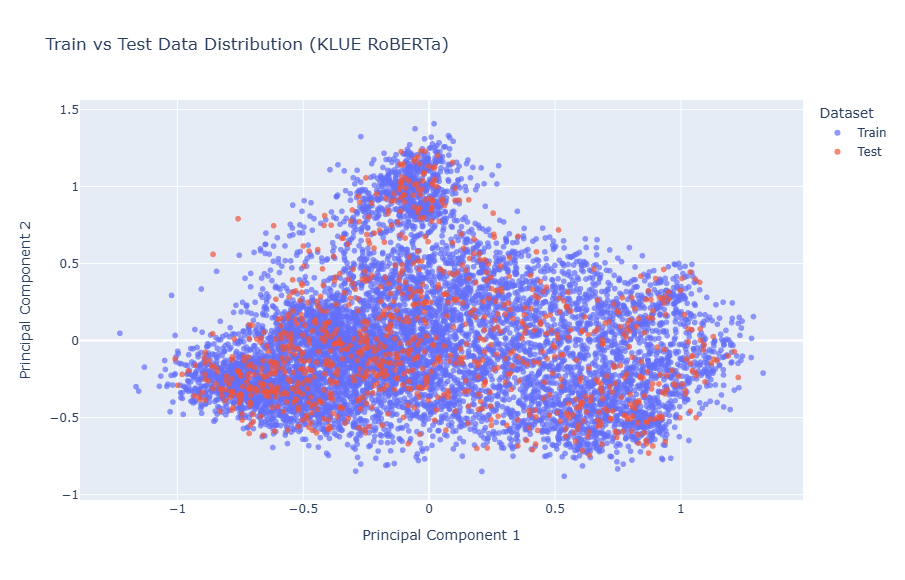